# Stock Price Prediction

## Imports

In [195]:
from pandas_datareader import data as pdr 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot 
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.metrics import mean_absolute_error

from random import gauss 
from random import seed
from pandas import Series
from sklearn.model_selection import train_test_split

## Download Data

In [196]:
def download_data(stock_ticker = "WMT",stock_start_date = None,stock_end_date = None):
    yf.pdr_override()
    if (stock_start_date is None) and (stock_end_date is None):
        stock_df = pdr.get_data_yahoo(stock_ticker)
    else:
        if stock_end_date is None:
            stock_end_date = datetime.date.today()
        else:
            stock_start_date = datetime.date(2020,1,1)
        stock_df = pdr.get_data_yahoo(stock_ticker,start=stock_start_date,end=stock_end_date)
    stock_df.to_csv("{}.csv".format(stock_ticker.lower()))

## Loading Data

In [197]:
walmart = pd.read_csv("walmart.csv")
d_walmart_df = walmart.copy()
d_walmart_df["Date"] = pd.to_datetime(d_walmart_df["Date"])
d_walmart_df = d_walmart_df.set_index('Date')
m_walmart_df = d_walmart_df.groupby(pd.Grouper(freq='MS')).median()

m_cpi_rate = pd.read_csv("cpi_rate.csv")
m_cpi_rate["DATE"] = pd.to_datetime(m_cpi_rate["DATE"])
m_cpi_rate = m_cpi_rate.set_index('DATE')
m_personal_sav_r = pd.read_csv("personal_saving_rate.csv")
m_personal_sav_r["DATE"] = pd.to_datetime(m_personal_sav_r["DATE"])
m_personal_sav_r = m_personal_sav_r.set_index('DATE')
m_personal_cons_exp = pd.read_csv("personal_consume_exp.csv")
m_personal_cons_exp["DATE"] = pd.to_datetime(m_personal_cons_exp["DATE"])
m_personal_cons_exp = m_personal_cons_exp.set_index('DATE')

print("Column List")
print("Walmart Cols:",d_walmart_df.columns)
print("CPI Rate Cols:",m_cpi_rate.columns)
print("Personal Savings Cols:",m_personal_sav_r.columns)
print("Personal Consumer Expenditure Cols:",m_personal_cons_exp.columns)

Column List
Walmart Cols: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
CPI Rate Cols: Index(['CPIAUCSL_PC1', 'CPILFESL_PC1'], dtype='object')
Personal Savings Cols: Index(['PSAVERT'], dtype='object')
Personal Consumer Expenditure Cols: Index(['PCE'], dtype='object')


## US Economic Factors
The collected US Economic Factors are CPI Rate, Personal Consumer Expenditure and Personal Savings Rate. 

The were selected for the following reasons:
1. ##### CPI Rate (Consumer Price Index):
    The CPI rate measures changes in the average prices paid by consumers for a basket of goods and services over time. As a retail company, Walmart's revenue and profitability are directly influenced by consumer spending. If the CPI rate is rising, it typically indicates inflation, which can affect consumer purchasing power. When the CPI increases, consumers may have less purchasing power, and this can impact Walmart's sales and profit margins.

2. ##### Personal Consumer Expenditure:
    Personal Consumer Expenditure data provides insights into how much consumers are spending on various goods and services. Walmart's revenue is highly dependent on consumer spending. A rise in personal consumer expenditure can suggest that people are willing to spend more, which may lead to increased sales for Walmart. On the other hand, a decrease in consumer expenditure can indicate economic challenges that may affect Walmart's performance.

3. ##### Personal Savings Rate:
    The personal savings rate reflects the percentage of income that individuals save rather than spend. It is an important indicator of consumer behavior. If the personal savings rate is high, it may indicate that consumers are saving more and spending less, which could lead to lower sales for retailers like Walmart. Conversely, a low personal savings rate might indicate increased consumer spending, potentially benefiting Walmart's sales.

##### Data Soure:
The data for the economic factors was sourced from Economic Research Federal Reserve Bank of St. Louis web page.

## Function to plot timeseries dataframes

In [198]:
def plot_ts(df,plot_col = "", ax = "",title = "Time Series Plot"):
    sns.lineplot(x=df.index, y=df[plot_col], ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel(plot_col)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    return ax

##  Relationship between selected stock and economic factors

### Plotting economic factors and stock chart

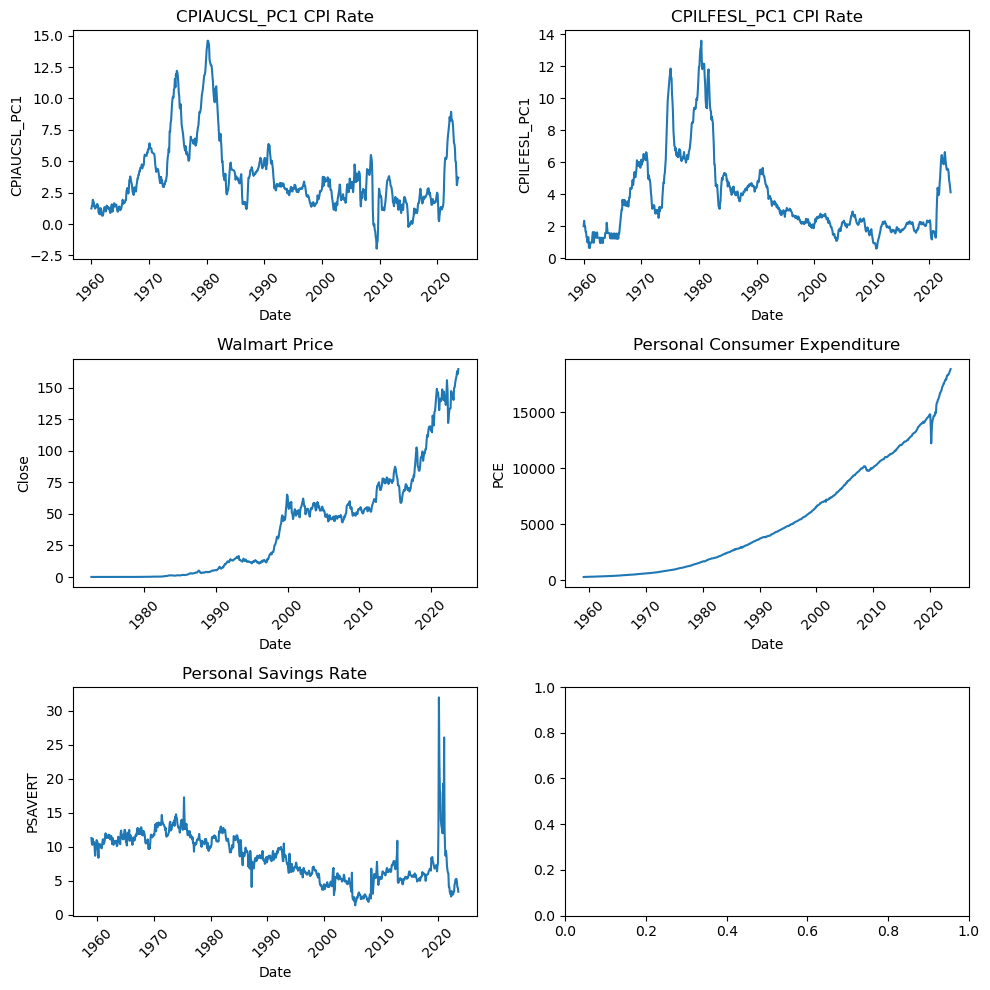

In [199]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plot_ts(m_cpi_rate, plot_col="CPIAUCSL_PC1", ax=axes[0][0],title = "CPIAUCSL_PC1 CPI Rate")
plot_ts(m_cpi_rate, plot_col="CPILFESL_PC1",  ax=axes[0][1],title = "CPILFESL_PC1 CPI Rate")
plot_ts(m_walmart_df,plot_col="Close",ax=axes[1][0],title="Walmart Price")
plot_ts(m_personal_cons_exp,plot_col="PCE",ax=axes[1][1],title="Personal Consumer Expenditure")
plot_ts(m_personal_sav_r,plot_col="PSAVERT",title="Personal Savings Rate",ax=axes[2][0])
plt.tight_layout()
plt.show()

In [200]:
# Filtering Data by Dates
m_walmart_df = m_walmart_df.loc['1972-08-01':'2023-09-01']
m_cpi_rate = m_cpi_rate.loc['1972-08-01':'2023-10-01']
m_personal_cons_exp = m_personal_cons_exp.loc['1972-08-01':'2023-10-01']
m_personal_sav_r = m_personal_sav_r.loc['1972-08-01':'2023-10-01']

In [201]:
# Dropping unecessary columns
m_walmart_df["Price"] = (m_walmart_df["Open"] + m_walmart_df["Close"])/2
m_walmart_df.drop(columns=["Open","High","Low","Close","Adj Close","Volume"],inplace=True)

m_cpi_rate.drop(columns=["CPILFESL_PC1"],inplace=True)

In [202]:
# Confirm if all dataframes are in the same time range
print("Walmart vs CPI:",m_walmart_df.index.difference(m_cpi_rate.index))
print("Walmart vs Personal Savings Rate:",m_walmart_df.index.difference(m_personal_sav_r.index))
print("Walmart vs Personal Consumer Spending:",m_walmart_df.index.difference(m_personal_cons_exp.index))

Walmart vs CPI: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Walmart vs Personal Savings Rate: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Walmart vs Personal Consumer Spending: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


#### Regression Analysis

MSE CPI Rate: 6838.407016613357 R2 Score: -6.280331183281158
MSE Consumer Spending: 639.9456967535226 R2 Score: 0.3186985506474601
MSE Savings Rate: 7705.431430372998 R2 Score: -7.203386049834924


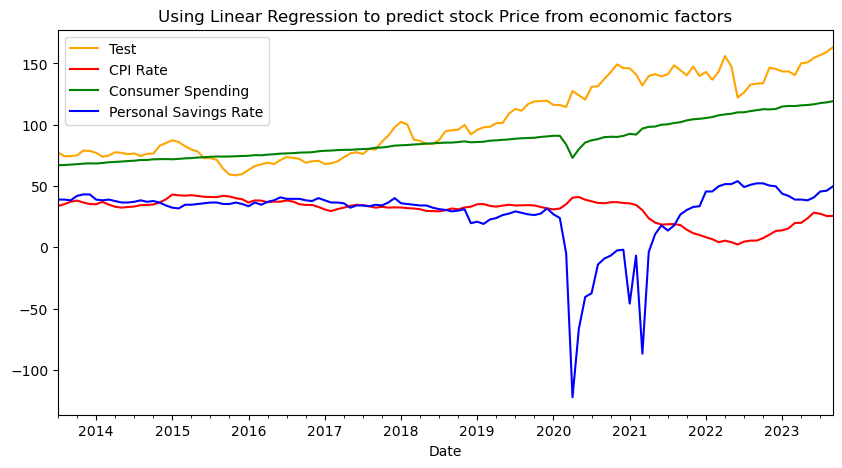

In [203]:
# Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



train_data, test_data = train_test_split(m_walmart_df, test_size=0.2, random_state=20, shuffle = False)

cpi_train_data, cpi_test_data = train_test_split(m_cpi_rate, test_size=0.2, random_state=20, shuffle = False)

con_train_data, con_test_data = train_test_split(m_personal_cons_exp, test_size=0.2, random_state=20, shuffle = False)

sav_train_data, sav_test_data = train_test_split(m_personal_sav_r, test_size=0.2, random_state=20, shuffle = False)


model = LinearRegression()


model.fit(cpi_train_data,train_data)
y_pred = model.predict(cpi_test_data)
mse = mean_squared_error(test_data["Price"], y_pred)
r2 = r2_score(test_data["Price"], y_pred)
print("MSE CPI Rate:",mse,"R2 Score:",r2)
test_data["cpi_pred"] = y_pred


model.fit(con_train_data,train_data)
y_pred = model.predict(con_test_data)
mse = mean_squared_error(test_data["Price"], y_pred)
r2 = r2_score(test_data["Price"], y_pred)
print("MSE Consumer Spending:",mse,"R2 Score:",r2)
test_data["con_pred"] = y_pred

model.fit(sav_train_data,train_data)
y_pred = model.predict(sav_test_data)
mse = mean_squared_error(test_data["Price"], y_pred)
r2 = r2_score(test_data["Price"], y_pred)
print("MSE Savings Rate:",mse,"R2 Score:",r2)
test_data["savr_pred"] = y_pred



plt.figure(figsize=(10, 5))
test_data['Price'].plot(label='Test',color = "orange")
test_data['cpi_pred'].plot(label='CPI Rate',color = "red")
test_data['con_pred'].plot(label='Consumer Spending',color = "green")
test_data['savr_pred'].plot(label='Personal Savings Rate',color = "blue")



plt.title('Using Linear Regression to predict stock Price from economic factors')
plt.xlabel('Date')
plt.legend()
plt.show()

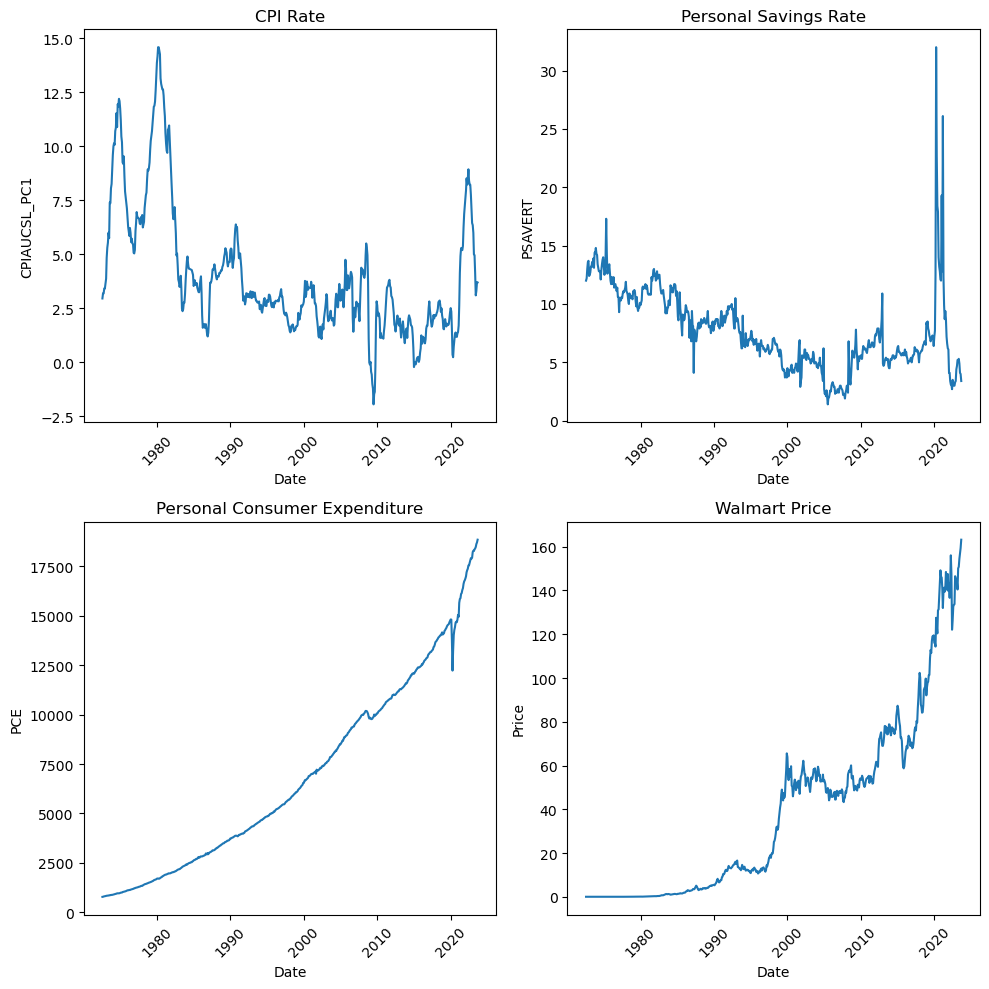

In [204]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plot_ts(m_cpi_rate, plot_col="CPIAUCSL_PC1", ax=axes[0][0],title = "CPI Rate")
plot_ts(m_walmart_df,plot_col="Price",ax=axes[1][1],title="Walmart Price")
plot_ts(m_personal_cons_exp,plot_col="PCE",ax=axes[1][0],title="Personal Consumer Expenditure")
plot_ts(m_personal_sav_r,plot_col="PSAVERT",title="Personal Savings Rate",ax=axes[0][1])
plt.tight_layout()
plt.show()

### Relationship between economic factors and stock

#### CPI Rate
    Based on the plot, we can conclude that the CPI Rate cannot be used to estimate the stock price. It appears to be bounded by a maximum and minimum value, fluctuating between these bounds. The only notable deviations occurred in 2010 and 2020, coinciding with significant fluctuations in Walmart's stock price. However, aside from these instances, we cannot derive any other predictive information.
#### Personal Savings Rate
    Interpreting the personal savings rate plot, it seems unsuitable for forecasting the magnitude of Walmart's stock price. However, it can be utilized to predict significant changes in the stock price. Whenever there is a major fluctuation in the personal savings rate, a corresponding change in Walmart's stock price is observed.
#### Personal Consumer Expenditure
    Among all economic factors, this is the only one that can be employed to forecast stock prices. The plot exhibits a similar trend to Walmart's stock price. Comparing the charts, it is evident that this factor resembles a smoothed, scaled version of the stock price plot.

## ETS Models

### AutoCorrelation Plot

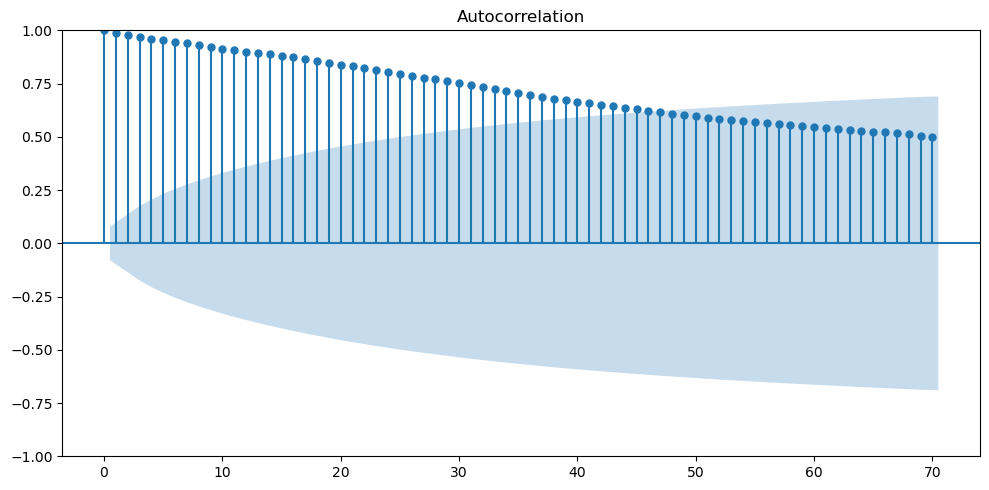

In [205]:
fig = plot_acf(m_walmart_df['Price'], lags=70)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

### Preparing Training and Test Data

No. of training examples: 492
No. of testing examples: 122


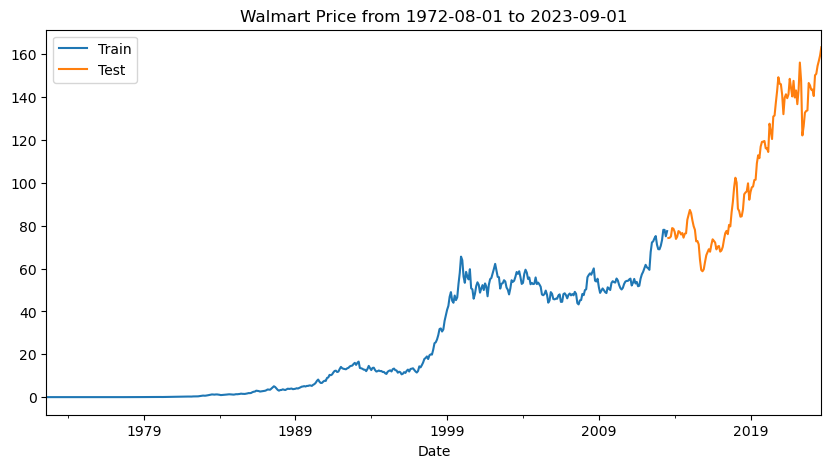

In [206]:
test_size = int(len(m_walmart_df)*0.2)

train_data, test_data = train_test_split(m_walmart_df, test_size=test_size, random_state=25, shuffle = False)

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")


plt.figure(figsize=(10, 5))
train_data['Price'].plot(label='Train')
test_data['Price'].plot(label='Test')
plt.title('Walmart Price from {} to {}'.format(str(m_walmart_df.index[0]).split()[0], str(m_walmart_df.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

### Training ETS Models

In [207]:
pts_to_pred = len(test_data)

# Simple Exponential Smoothing - No trend No seasonality
ses = SimpleExpSmoothing(train_data).fit(smoothing_level=0.7,optimized=False)
ses_forecast = ses.forecast(pts_to_pred)

# Double Exponential Smoothing / Holts Exponential Smoothing - Trend but No seasonality
des = ExponentialSmoothing(train_data, trend="mul").fit()
des_forecast = des.forecast(pts_to_pred)

# Triple Exponential Smoothing - Winters Exponential Smoothing - Trend and Seasonality
tes = ExponentialSmoothing(train_data,trend="mul",seasonal="add",seasonal_periods=10).fit()
tes_forecast = tes.forecast(pts_to_pred)

/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### Plotting Predictions

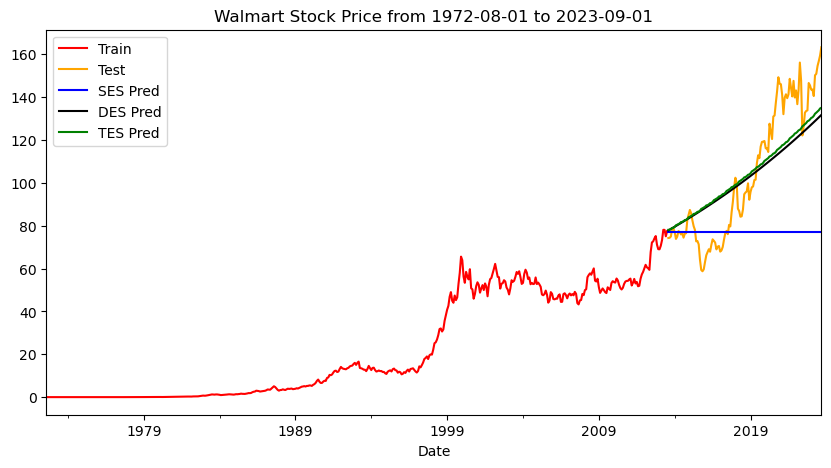

In [208]:
plt.figure(figsize=(10, 5))

# TRAIN
train_data['Price'].plot(label='Train',color= "red")
# TEST
test_data['Price'].plot(label='Test',color = "orange")

# SES
# ses.fittedvalues.plot(label = "SES Train",color="blue")
ses_forecast.plot(label="SES Pred",color = "blue")

# DES / HES
# des.fittedvalues.plot(label = "DES Train",color="yellow")
des_forecast.plot(label="DES Pred",color = "black")

# TES / WES
# tes.fittedvalues.plot(label = "TES Train",color="green")
tes_forecast.plot(label="TES Pred",color = "green")


plt.title('Walmart Stock Price from {} to {}'.format(str(m_walmart_df.index[0]).split()[0], str(m_walmart_df.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

## Error Calculation Using Metrics

In [209]:
# Function to calculate Errors
def errors(truth = np.array([[1,1]]),pred = np.array([[1,1]])):
    from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

    error_str = "\n\
    Mean Squared Error: {:0.3f}\n\
    Mean Absolute Error: {:0.3f}\n\
    Mean Absolute Percentage Error: {:0.3f}\n\
    Weighted Mean Squared Error: {:0.3f}\n\
    Mean Forecast Error: {:0.3f}\n\
    ".format(mean_squared_error(truth,pred)**0.5,
    mean_absolute_error(truth,pred),
    mean_absolute_percentage_error(truth,pred),
    mean_squared_error(truth,pred,sample_weight=np.exp(-np.arange(len(truth)))),
    # mean_squared_error(truth,pred),
    np.mean(truth-pred))
    return error_str

### Calculating Error

In [210]:
error_ses = test_data.values - ses_forecast.values.reshape(pts_to_pred,1)
error_des = test_data.values - des_forecast.values.reshape(pts_to_pred,1)
error_tes = test_data.values - tes_forecast.values.reshape(pts_to_pred,1)

### Plotting Error

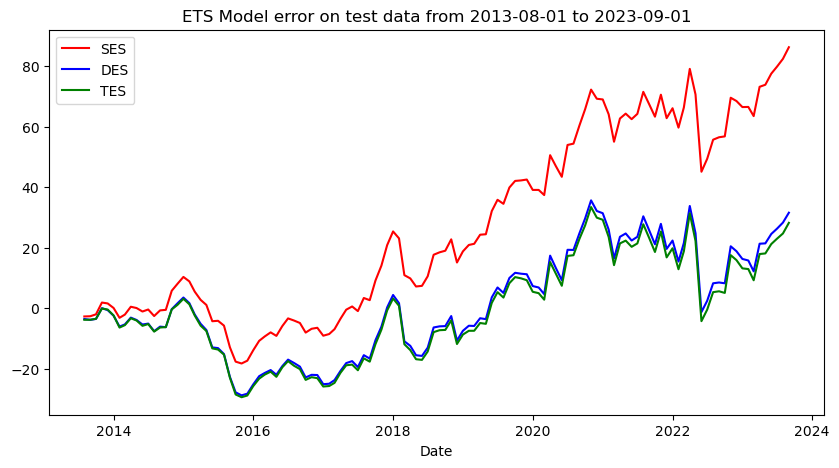

In [211]:
plt.figure(figsize=(10, 5))
plt.plot(test_data.index,error_ses,label = "SES",color = "red")
plt.plot(test_data.index,error_des,label = "DES",color = "blue")
plt.plot(test_data.index,error_tes,label = "TES",color = "green")
plt.title('ETS Model error on test data from {} to {}'.format(str(test_data.index[0]).split()[0], str(test_data.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

### Errors

In [212]:
print("Error Values for SES Model is:")
print(errors(test_data.values,ses_forecast.values))

print("\nError Values for DES Model is:")
print(errors(test_data.values,des_forecast.values))

print("\nError Values for TES Model is:")
print(errors(test_data.values,tes_forecast.values))

Error Values for SES Model is:

    Mean Squared Error: 40.738
    Mean Absolute Error: 30.364
    Mean Absolute Percentage Error: 0.245
    Weighted Mean Squared Error: 6.699
    Mean Forecast Error: 26.800
    

Error Values for DES Model is:

    Mean Squared Error: 17.241
    Mean Absolute Error: 14.508
    Mean Absolute Percentage Error: 0.147
    Weighted Mean Squared Error: 12.441
    Mean Forecast Error: 1.374
    

Error Values for TES Model is:

    Mean Squared Error: 16.459
    Mean Absolute Error: 13.876
    Mean Absolute Percentage Error: 0.145
    Weighted Mean Squared Error: 13.588
    Mean Forecast Error: -0.076
    


## Evaluation

###  Model Evaluation
    In evaluating multiple ETS (Exponential Smoothing State Space) models—Simple Exponential Smoothing (SES), Double Exponential Smoothing (DES), and Triple Exponential Smoothing (TES)—based on the above error metrics. The SES model exhibits the highest error values across various metrics, indicating limitations in capturing underlying patterns in the time series data. As we progress to DES, there is a notable improvement in all error measures, suggesting enhanced forecasting accuracy. However, it is the TES model that stands out as the most effective in terms of accuracy metrics. With the lowest values for Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), Weighted Mean Squared Error (WMSE), and Mean Forecast Error (MFE), TES demonstrates superior predictive capabilities. This can be attributed to TES's ability to account for seasonality, trend, and level components, providing a more nuanced and accurate representation of the time series data. Therefore, the Triple Exponential Smoothing model is the best model in this scenario for univariate forecasting, surpassing the simpler SES and DES models in predictive performance.

### Metric Justification
##### Weighted Mean Squared Error
    Weighted Mean Squared Error is similar to root mean squared error, but the key distinction lies in assigning higher weights to more recent samples compared to older samples. This approach enables us to assess the model's accuracy with a greater emphasis on recent data. The rationale behind selecting this metric is rooted in the task of forecasting the median price. Emphasizing lower loss on recent dates is deemed more crucial than on older dates. By training our model using this weighted loss, we aim to instill a preference for recent samples and, over time, develop a generalized function that exhibits a slight bias towards recent examples. This is particularly beneficial in addressing distribution shifts, a common occurrence in stock prices.
##### Mean Forecast Error
    The Mean Forecast Error computes the average difference between actual and predicted values, offering valuable insights into the magnitude and bias of errors. This metric plays a crucial role in understanding the overall error and guides the correction of model predictions. By assessing both the size and direction of errors, it facilitates adjustments that contribute to refining our forecasting accuracy and aligning predictions more closely with the ground truth.

